<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# autoreload updated and newly installed packages
# without having to restart Jupyter kernel
%load_ext autoreload
%autoreload 2
# Some little interaction with matplotlib
%matplotlib inline                
# Avoid using Jedi for faster autocomplete (tab)
%config Completer.use_jedi = False

## Crack growth analysis

### Hollow cylinder with crack on the external surface 

In [2]:
# Standard imports
import datetime
import platform
import os
import sys
from typing import List
# Non-standard imports
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import plotly.graph_objs as go
# py-fatigue import
import py_fatigue as pf
import py_fatigue.testing as test
# Paths of this tutorial and of the data
TUTORIAL_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(TUTORIAL_PATH, "Data")
if not TUTORIAL_PATH in sys.path:
    sys.path.append(TUTORIAL_PATH)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"py-fatigue version: {pf.styling.TermColors.CBOLD}{pf.__version__}")

print(f"{pf.styling.TermColors.CWHITEBG}\
{pf.styling.TermColors.CBOLD}\
{pf.styling.TermColors.CBLUE}")
      
print(f"DATA_PATH = {DATA_PATH}")
print(f"TUTORIAL_PATH = {TUTORIAL_PATH}")

print(f"{pf.styling.TermColors.CEND}")

Platform: Linux-6.5.0-1025-oem-x86_64-with-glibc2.35
Python version: 3.9.19 (main, Sep  2 2024, 18:33:51) 
[GCC 11.4.0]
py-fatigue version: 1.0.20

DATA_PATH = /home/pita/Projects/py_fatigue/Data
TUTORIAL_PATH = /home/pita/Projects/py_fatigue



In [4]:
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["font.family"] = ["serif"]
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 3
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = True

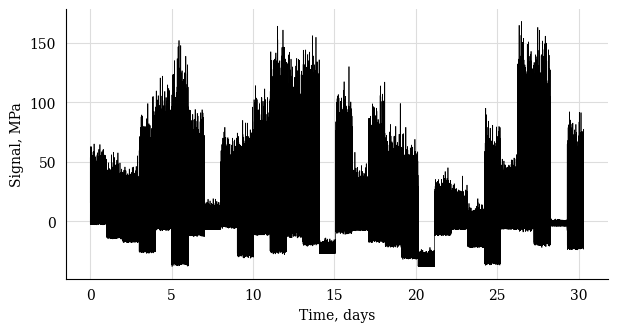

In [5]:
from collections import defaultdict

import py_fatigue.testing as test

np.random.seed(100)

signal_duration = int(86400 / 60)  # (in minutes)
max_peak = 200  # (in MPa)

# list of timestamps
timestamps = []

# list of timeseries
timeseries = []

# concatenated time and stress arrays
conc_time = np.empty(0)
conc_stress = np.empty(0)

# main loop
for i in range(0, 30):
    np.random.seed(i)
    print(f"{i+1} / 30", end = "\r")
    min_ = - np.random.randint(3, 40)
    range_ = np.random.randint(1, 200)
    timestamps.append(
        datetime.datetime(2020, 1, i + 1, tzinfo=datetime.timezone.utc)
    )
    timeseries.append(defaultdict())
    
    time = test.get_sampled_time(duration=signal_duration, fs=10, start=i)
    stress = test.get_random_data(
        t=time, min_=min_, range_=range_, random_type="weibull", a=2., seed=i
    )
    conc_time = np.hstack(
        [conc_time, time + conc_time[-1] if len(conc_time) > 0 else time]
    )
    conc_stress = np.hstack([conc_stress, stress])
    timeseries[i]["data"] = stress
    timeseries[i]["time"] = time
    timeseries[i]["timestamp"] = timestamps[-1]
    timeseries[i]["name"] = "Example sum"

# Generating the timeseries dictionary
timeseries.append({
    "data": conc_stress,
    "time": conc_time,
    "timestamp": timestamps[0],
    "name": "Concatenated",
    "range_bin_width":  5.0,
    "mean_bin_width":  5.0,
})

# concatenated timeseries plot
plt.plot(conc_time/60/24, conc_stress, 'k', lw=0.5)
plt.xlabel("Time, days")
plt.ylabel("Signal, MPa")
plt.show()

In [6]:
cc = []
for t_s in timeseries:
    cc.append(pf.CycleCount.from_timeseries(**t_s))

# sum of the CycleCount instances
cc_sum = sum(cc[:-1])

# CyclCeCount from concatenated data
cc_conc = pf.CycleCount.from_timeseries(**timeseries[-1])

In [7]:
cc_conc

,Concatenated
Cycle counting object,
"largest full stress range, MPa",189.71765
"largest stress range, MPa",206.0
number of full cycles,143860
number of residuals,31
number of small cycles,0
stress concentration factor,N/A
residuals resolved,False
mean stress-corrected,No


In [8]:
cc_sum.solve_lffd()

,Example sum
Cycle counting object,
"largest full stress range, MPa",189.71765
"largest stress range, MPa",206.0
number of full cycles,143860
number of residuals,31
number of small cycles,0
stress concentration factor,N/A
residuals resolved,True
mean stress-corrected,No


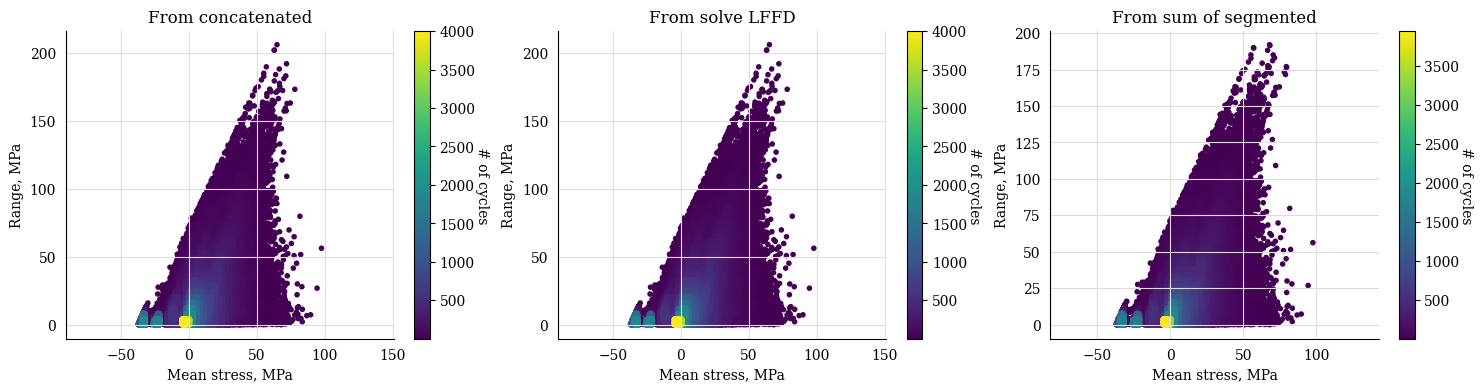

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
cc_conc.plot_histogram(fig=fig, ax=axs[0], plot_type="mean-range")
cc_sum.solve_lffd().plot_histogram(fig=fig, ax=axs[1], plot_type="mean-range")
cc_sum.plot_histogram(fig=fig, ax=axs[2], plot_type="mean-range")
axs[0].set_title("From concatenated")
axs[1].set_title("From solve LFFD")
axs[2].set_title("From sum of segmented")

plt.show()

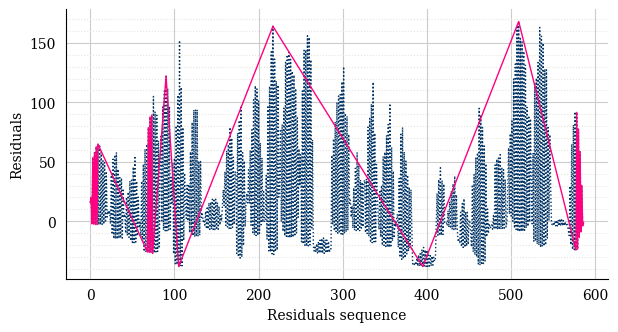

In [10]:
cc_sum.plot_half_cycles_sequence(lw=1)
plt.show()